# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [4]:
from itertools import product 
from tqdm.notebook import tqdm

In [5]:
from dash import Dash, dcc, Output, Input 
import dash_bootstrap_components as dbc   
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1D example

In [6]:
def f_1d_toy(x):
    if 2 <= x.item() <= 3:
        f = \
            -1600 * (x - 2.5) ** 5 - \
            2000 * (x - 2.5) ** 4 + \
            800 * (x - 2.5) ** 3 + \
            1020 * (x - 2.5) ** 2 

    elif 8.4 <= x.item() <= 8.40001:
        f = 1411.2 * (1 - 1e4 * (x - 8.4))

    elif 8.40001 <= x.item() <= 8.59999:

        f = x * 0

    elif 8.59999 <= x.item() <= 8.6:
        f = 1479.2 * (1e4 * (x - 8.6) + 1)

    else:
        f = 20 * x ** 2

    return f

In [7]:
xs = np.arange(-2, 10, 1e-3)
xs_torch = [torch.tensor([x]) for x in xs]
ys_torch = [f_1d_toy(x) for x in xs_torch]
ys = [y.item() for y in ys_torch]

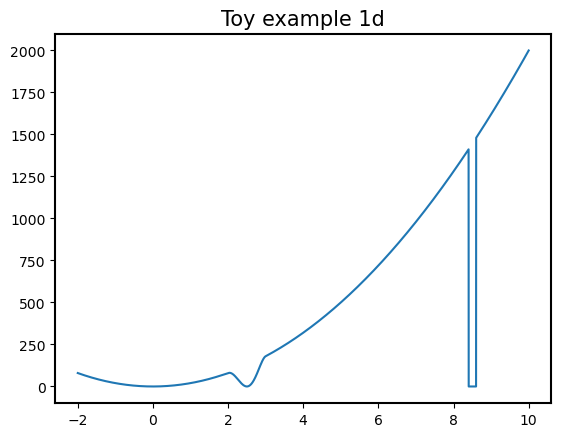

In [8]:
plt.plot(xs, ys)
plt.title('Toy example 1d')
plt.show()

In [9]:
def run_gd(func, lr, x_start_value, max_iter, return_null_if_fail=False):
    x = torch.tensor(x_start_value, requires_grad=True)
    optimizer = optim.SGD([x], lr=lr)
    x_hist_torch = []

    n_iter = 0

    while len(x_hist_torch) == 0 or \
        torch.norm(x - x_hist_torch[-1]) > 1e-6 and \
        n_iter < max_iter:

        x_hist_torch.append(x.detach().clone())

        optimizer.zero_grad()
        func(x).backward()

        optimizer.step()
        n_iter += 1

    x_hist_torch.append(x.detach().clone())

    if n_iter >= max_iter and return_null_if_fail:
        x_hist_torch.append(torch.zeros_like(x) / 0)

    return x_hist_torch

In [10]:
def x_to_minima_type(x):
    if -1e-2 < x < 1e-2:
        return 'The Good'
    
    elif -1e-2 < x - 2.5 < 1e-2:
        return 'The Bad'
    
    elif 8.4 < x < 8.6:
        return 'The Ugly'
    
    return None 

In [11]:
def create_df_1d_toy(lrs, start_points, max_iter, xs, steps_cond=None):
    if steps_cond is None:
        steps_cond = lambda steps: steps >= 0

    xs_torch = [torch.tensor([x]) for x in xs]
    ys_torch = [f_1d_toy(x) for x in xs_torch]
    ys = [y.item() for y in ys_torch]

    df_1d_toy = pd.DataFrame({
        'x': xs, 
        'y': ys, 
        'type': 'func', 
        'lr': np.nan, 
        'step': np.nan,
        'start_point': np.nan,
    })

    for lr, start_point in tqdm(product(lrs, start_points)):    
        x_hist_torch = run_gd(f_1d_toy, lr, [start_point], max_iter)
        y_hist_torch = [f_1d_toy(x) for x in x_hist_torch]
        x_hist = np.array([x.item() for x in x_hist_torch])
        y_hist = np.array([y.item() for y in y_hist_torch])
        steps = np.arange(len(x_hist)) + 1.

        inds = steps_cond(steps)

        x_hist = x_hist[inds]
        y_hist = y_hist[inds]
        steps = steps[inds]

        df_1d_toy = pd.concat([
            df_1d_toy,
            pd.DataFrame({
                'x': x_hist, 
                'y': y_hist, 
                'type': 'gd', 
                'lr': lr, 
                'step': steps,
                'start_point': start_point,
            })
        ])

    df_1d_toy['minima_type'] = df_1d_toy['x'].apply(x_to_minima_type)
    return df_1d_toy

In [12]:
lrs = np.logspace(-4, -0.5, 20)
x_starts = np.linspace(8.5, 10, 25)

df_1d = create_df_1d_toy(lrs, x_starts, 1e3, np.linspace(-2, 10, 300))

0it [00:00, ?it/s]

In [13]:
df_1d.to_parquet('dash_data/df_1d.parquet')

In [14]:
lrs_1d = df_1d['lr'].dropna().unique()
lrs_1d.sort()
lrs_1d_marks = {i: lr for i, lr in enumerate(lrs_1d)}

start_points_1d = df_1d['start_point'].dropna().unique()
start_points_1d.sort()
start_points_1d_marks = {i: x for i, x in enumerate(start_points_1d)}

In [92]:
def create_fig_1d(lr, start_point, df_1d_toy):

    fig_line = px.line(
        data_frame=df_1d_toy.query('type == "func"'), 
        x='x', 
        y='y'
    )

    fig_scatter = px.scatter(
        data_frame=df_1d_toy\
            .query('type == "func"')\
            .sort_values('y')\
            .groupby('minima_type', as_index=False)\
            .first()\
            .sort_values('minima_type'),
        x='x',
        y='y',
        color='minima_type', 
        symbol='minima_type',
        symbol_sequence=['square', 'diamond', 'x']
    )

    fig_scatter.update_traces(marker_size=12)

    x_min_func = df_1d_toy.query('type == "func"')['x'].min()
    x_max_func = df_1d_toy.query('type == "func"')['x'].max()

    fig_scatter_gd = px.scatter(
        data_frame=df_1d_toy.query(
            '''
            (type == "gd") & (x >= @x_min_func) & (x <= @x_max_func) & (lr == @lr) & (start_point == @start_point)
            '''
        ),
        x='x',
        y='y',
        color='step'
    )#.update_traces(mode="lines+markers")

    fig_scatter_gd.update_traces(marker_size=8)


    fig_1d = go.Figure(data=fig_line.data + fig_scatter.data + fig_scatter_gd.data)

    fig_1d.update_layout(
        title={
            'text': f'1D Toy example with lr={lr:.4f} x_start={start_point:.2f}', 
            'x':0.5,
            'xanchor': 'center',
        }
    )

    fig_1d.update(layout_coloraxis_showscale=False)


    return fig_1d

In [93]:
def create_fig_1d_ends(df_1d_toy):
    fig_ends = px.scatter(
        df_1d\
            .query('type == "gd"')\
            .sort_values('step')\
            .groupby(['lr', 'start_point'], as_index=False)\
            .last()\
            .sort_values('minima_type'),
        x='start_point',
        y='lr',
        color='minima_type',
        symbol='minima_type',
        log_y=True,
        symbol_sequence=['square', 'diamond', 'x']
    ).update_traces(marker_size=12)

    return fig_ends

In [94]:
fig = create_fig_1d(lrs_1d_marks[2], start_points_1d_marks[4], df_1d)

In [95]:
fig.show()

In [97]:
px.scatter(
    df_1d\
        .query('type == "gd"')\
        .sort_values('step')\
        .groupby(['lr', 'start_point'], as_index=False)\
        .last()\
        .sort_values('minima_type'),
    x='start_point',
    y='lr',
    color='minima_type',
    symbol='minima_type',
    log_y=True,
    symbol_sequence=['square', 'diamond', 'x']

).update_traces(marker_size=12)

# 2D

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [21]:
import torch.nn.functional as F

In [22]:
def f_2d_toy(x, y):
    f_A = x ** 2 + y ** 2
    f_B = 200 * \
        F.relu(torch.abs(x) - 1) * \
        F.relu(torch.abs(y) - 1) * \
        F.relu(2 - torch.abs(x)) * \
        F.relu(2 - torch.abs(y))

    return f_A - f_B

In [23]:
x = torch.linspace(-3, 3, 40)
y = torch.linspace(-3, 3, 40)

grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

In [24]:
grid_z = f_2d_toy(grid_x, grid_y)

In [25]:
np.save('dash_data/grid_x_2d', grid_x.numpy())
np.save('dash_data/grid_y_2d', grid_y.numpy())
np.save('dash_data/grid_z_2d', grid_z.numpy())

In [26]:
lrs = np.logspace(-3, -1, 10)
df_2d_func = pd.DataFrame({'x': [], 'y': [], 'z': [], 'lr': []})

for lr in lrs:
    x_hist = run_gd(lambda x: f_2d_toy(x[0], x[1]), lr, [3., 2.5], max_iter=1e4)
    xs = np.array([x[0].item() for x in x_hist])
    ys = np.array([x[1].item() for x in x_hist])
    zs = f_2d_toy(torch.tensor(xs), torch.tensor(ys)).numpy()

    df_2d_func = pd.concat([
        df_2d_func,
        pd.DataFrame({'x': xs, 'y': ys, 'z': zs, 'lr': lr})
    ])


In [27]:
df_2d_func.to_parquet('dash_data/df_2d_func_gd.parquet')

In [28]:
fig = go.Figure(
    data=[
        go.Surface(
            x=grid_x.numpy(), 
            y=grid_y.numpy(), 
            z=grid_z.numpy(), 
            colorscale='Viridis', 
            showscale=False
        ),
        go.Scatter3d(
            x=xs, y=ys, z=zs,
        )
    ],
)

fig.update_layout(
    title={
        'text': f'GD converged to flat minima lr=0.01', 
        'x':0.5,
        'xanchor': 'center',
    }
)

fig.show()

In [29]:
x_hist = run_gd(lambda x: f_2d_toy(x[0], x[1]), 0.005, [3., 2.5], max_iter=1e4)
xs = np.array([x[0].item() for x in x_hist])
ys = np.array([x[1].item() for x in x_hist])
zs = f_2d_toy(torch.tensor(xs), torch.tensor(ys)).numpy()
fig = go.Figure(
    data=[
        go.Surface(
            x=grid_x.numpy(), 
            y=grid_y.numpy(), 
            z=grid_z.numpy(), 
            colorscale='Viridis', 
            showscale=False
        ),
        go.Scatter3d(
            x=xs, y=ys, z=zs, marker={'size': 5}
        )
    ]
).update_layout(
    title={
        'text': f'GD converged to sharp minima lr=0.005', 
        'x':0.5,
        'xanchor': 'center',
    }
)


fig.show()

In [30]:
lrs = np.logspace(-1.75, -1.6, 25)

x_starts = np.random.uniform(3, 4, size=(30, 2))
x_ends = np.zeros((len(lrs), len(x_starts), 2), dtype=float)
z_ends = np.zeros((len(lrs), len(x_starts)), dtype=float)

40
for (lr_i, lr), (x_start_i, x_start) in tqdm(
    product(enumerate(lrs), enumerate(x_starts))
):
    ends = run_gd(lambda x: f_2d_toy(x[0], x[1]), lr, x_start, 1e4)[-1]
    x_ends[lr_i, x_start_i] = ends.numpy()
    z_ends[lr_i, x_start_i] = f_2d_toy(ends[0], ends[1]).item()


0it [00:00, ?it/s]

In [31]:
z_ends_df = pd.DataFrame(z_ends, columns=[f'x_start_{i}' for i in range(len(x_starts))])
z_ends_df['lr'] = lrs
z_ends_df = z_ends_df.melt(id_vars='lr', value_vars=[f'x_start_{i}' for i in range(len(x_starts))])
z_ends_df['log_lr'] = np.log10(z_ends_df['lr']).astype(int)

In [32]:
def map_val_to_type(z):
    if z < -8:
        return 'sharp minima'

    elif -1e-2 < z < 1e-2:
        return 'flat minima'
    
    else:
        return 'did not converge'

z_ends_df['type_minima'] = z_ends_df['value'].apply(map_val_to_type)

In [33]:
ends_counts = (z_ends_df
    .groupby('lr')
    ['type_minima']
    .value_counts()
    .to_frame()
    .set_axis(['counts'], axis=1)
    .reset_index()
)

ends_counts['fraction'] = ends_counts.groupby('lr')['counts'].transform(lambda s_: s_/s_.sum())

In [34]:
ends_counts = ends_counts.merge(
    pd.merge(
        ends_counts[['lr']].drop_duplicates(), 
        ends_counts[['type_minima']].drop_duplicates(),
        how='cross'
    ),
    on=['lr', 'type_minima'],
    how='outer'
).fillna(0)

In [35]:
ends_counts.to_parquet('dash_data/df_2d_ends.parquet')

In [36]:
px.line(
    data_frame=ends_counts.sort_values('lr'), 
    x='lr', 
    y='fraction', 
    color='type_minima', 
    line_dash='type_minima'
).update_layout(
    title={
        'text': 'fraction of types of minima obtained', 
        'x':0.5,
        'xanchor': 'center',
    }
)

# NN example

In [37]:
import seaborn_image as isns
from torch import nn

In [38]:
torch.cuda.is_available()

True

In [39]:
device = torch.device("cuda")

# Mnist

In [40]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 512
trainset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True, 
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True, 
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2
)

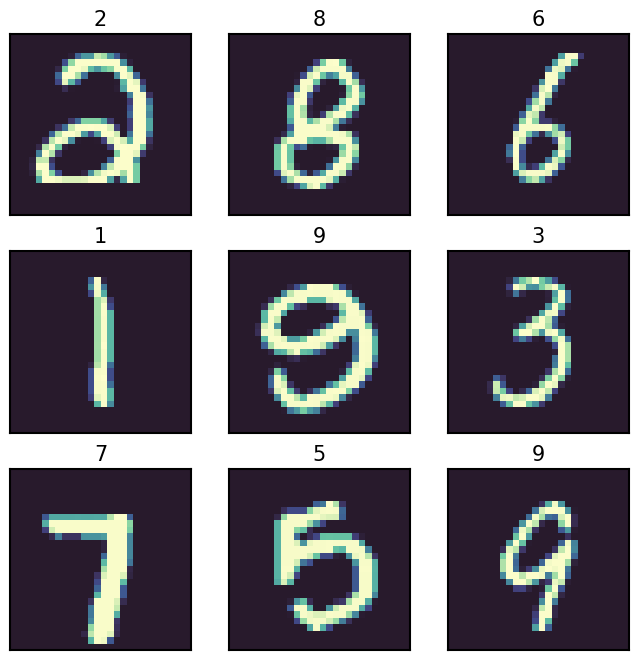

In [41]:
rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

for i, j in product(range(rows), range(cols)):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    sample_img , sample_lbl = trainset[sample_idx]

    axs[i, j].set_title(sample_lbl)
    isns.imgplot(sample_img.numpy()[0][::-1], ax=axs[i, j], cbar=False)

plt.show()

In [42]:
class MyLittleNN(nn.Module):
    def __init__(self, random_seed):
        torch.manual_seed(random_seed)
        super(MyLittleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
            ## Softmax layer ignored since the loss function defined is nn.CrossEntropy()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

In [43]:
def train_epoch(dataloader, model, loss_fn, optimizer, path_length=None):
    model.train()

    if path_length is not None:
        params_hist = []
        params_nbatches = len(dataloader) // path_length


    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if path_length is not None and batch % params_nbatches == 0:
            params_hist.append( 
                # np.concatenate([p.cpu().detach().numpy().reshape(-1) for p in model.parameters()]) 
                next(model.parameters()).cpu().detach().numpy().reshape(-1)
            )

    if path_length is not None:
        return params_hist
        

In [44]:
def validation(dataloader, model, loss_fn):
    size = 0
    correct = 0
    loss = 0

    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            size += len(y)

            pred = model(X)
            loss += loss_fn(pred, y).item()

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    return loss, correct / size

In [45]:
def train(trainloader, testloader, model, loss_fn, optimizer, epochs, path_length):
    
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    params_hist = []

    for epoch in range(epochs):
        print(f'EPOCH {epoch}')
        
        print('TRAIN')
        _param_hist = train_epoch(trainloader, model, loss_fn, optimizer, path_length // epochs)

        params_hist += _param_hist

        _train_loss, _train_accuracy = validation(trainloader, model, loss_fn)
        _test_loss, _test_accuracy = validation(testloader, model, loss_fn)

        print(f'TRAIN loss {_train_loss:.2f} accuracy {_train_accuracy:.2f}')
        print(f'TEST loss {_test_loss:.2f} accuracy {_test_accuracy:.2f}')

        train_loss.append(_train_loss)
        train_accuracy.append(_train_accuracy)
        test_loss.append(_test_loss)
        test_accuracy.append(_test_accuracy)

    return train_loss, train_accuracy, test_loss, test_accuracy, params_hist


In [46]:
from copy import deepcopy

In [47]:
model_A = MyLittleNN(random_seed=42).to(device)
model_B = MyLittleNN(random_seed=314).to(device)
model_C = MyLittleNN(random_seed=23).to(device)

model_stages = {
    'A_small': {
        'model': deepcopy(model_A),
        'lr': 1e-2,
        'epochs': 75,
        'path_length': 500
    },
    'A_medium': {
        'model': deepcopy(model_A),
        'lr': 5e-2,
        'epochs': 25,
        'path_length': 500
    },
    'A_large': {
        'model': deepcopy(model_A),
        'lr': 1e-1,
        'epochs': 10,
        'path_length': 500
    },
    'B_small': {
        'model': deepcopy(model_B),
        'lr': 1e-2,
        'epochs': 75,
        'path_length': 500
    },
    'B_medium': {
        'model': deepcopy(model_B),
        'lr': 5e-2,
        'epochs': 25,
        'path_length': 500
    },
    'B_large': {
        'model': deepcopy(model_B),
        'lr': 1e-1,
        'epochs': 10,
        'path_length': 500
    },
    'C_small': {
        'model': deepcopy(model_C),
        'lr': 1e-2,
        'epochs': 75,
        'path_length': 500
    },
    'C_medium': {
        'model': deepcopy(model_C),
        'lr': 5e-2,
        'epochs': 25,
        'path_length': 500
    },
    'C_large': {
        'model': deepcopy(model_C),
        'lr': 1e-1,
        'epochs': 10,
        'path_length': 500
    },
    
}

In [48]:
from types import SimpleNamespace

In [49]:
loss_fn = nn.CrossEntropyLoss()

params_df = []
losses_df = []

for name, params in model_stages.items():

    model = params['model']
    lr = params['lr']
    epochs = params['epochs']
    path_length = params['path_length']

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_loss, train_accuracy, test_loss, test_accuracy, params_hist = train(
        trainloader, 
        testloader, 
        model, 
        loss_fn, 
        optimizer, 
        epochs=epochs, 
        path_length=path_length
    )

    losses_df.append(
        pd.DataFrame({
            'strategy_name': name,
            'lr': lr,
            'train_loss': train_loss, 
            'test_loss': test_loss, 
            'train_acc': train_accuracy,
            'test_acc': test_accuracy
        })
    )

    params_df.append(
        pd.DataFrame(
            data=params_hist, 
            columns=[f'param_{i + 1}' for i in range(len(params_hist[0]))]
        ).assign(strategy_name=name, lr=lr)
    )


EPOCH 0
TRAIN
TRAIN loss 256.84 accuracy 0.32
TEST loss 43.47 accuracy 0.32
EPOCH 1
TRAIN
TRAIN loss 218.68 accuracy 0.55
TEST loss 36.89 accuracy 0.55
EPOCH 2
TRAIN
TRAIN loss 163.89 accuracy 0.65
TEST loss 27.46 accuracy 0.66
EPOCH 3
TRAIN
TRAIN loss 117.25 accuracy 0.74
TEST loss 19.52 accuracy 0.75
EPOCH 4
TRAIN
TRAIN loss 91.72 accuracy 0.79
TEST loss 15.13 accuracy 0.80
EPOCH 5
TRAIN
TRAIN loss 78.06 accuracy 0.81
TEST loss 12.83 accuracy 0.82
EPOCH 6
TRAIN
TRAIN loss 69.79 accuracy 0.83
TEST loss 11.41 accuracy 0.83
EPOCH 7
TRAIN
TRAIN loss 65.39 accuracy 0.84
TEST loss 10.68 accuracy 0.84
EPOCH 8
TRAIN
TRAIN loss 61.11 accuracy 0.85
TEST loss 10.01 accuracy 0.86
EPOCH 9
TRAIN
TRAIN loss 58.28 accuracy 0.86
TEST loss 9.53 accuracy 0.86
EPOCH 10
TRAIN
TRAIN loss 55.73 accuracy 0.86
TEST loss 9.12 accuracy 0.87
EPOCH 11
TRAIN
TRAIN loss 54.77 accuracy 0.87
TEST loss 8.93 accuracy 0.88
EPOCH 12
TRAIN
TRAIN loss 51.93 accuracy 0.88
TEST loss 8.43 accuracy 0.88
EPOCH 13
TRAIN
TRAIN l

In [50]:
losses_df = pd.concat(losses_df)
params_df = pd.concat(params_df)

In [66]:
losses_df['step'] = losses_df.groupby('strategy_name')['lr'].transform(lambda s_: np.arange(len(s_)) + 1)
params_df['step'] = params_df.groupby('strategy_name')['lr'].transform(lambda s_: np.arange(len(s_)) + 1)

In [67]:
losses_df['step_normed'] = losses_df.groupby('strategy_name', as_index=False)['step'].transform(lambda s_: (s_ - 1) / s_.max())
losses_df.sort_values('step_normed', inplace=True)

In [68]:
params_df.to_parquet('dash_data/params_df.parquet')
losses_df.to_parquet('dash_data/losses_df.parquet')

In [69]:
params_df.query('step == 1')

,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8,param_9,param_10,...,param_25082,param_25083,param_25084,param_25085,param_25086,param_25087,param_25088,strategy_name,lr,step
0,0.027323,0.029661,-0.008349,0.032826,-0.007807,0.007225,-0.017370,0.020992,0.031502,-0.026183,...,-0.009923,-0.028943,0.027496,-0.025988,-0.019253,0.017045,0.024648,A_small,0.01,1
0,-0.005058,-0.015014,-0.005474,-0.010144,0.032760,-0.027794,-0.014695,0.030106,0.006325,-0.026369,...,0.034147,-0.027018,0.008004,-0.022563,-0.001679,0.007019,-0.026776,C_large,0.10,1
0,0.015689,0.009250,0.011910,-0.011535,0.025159,-0.013388,0.000042,-0.002551,-0.035123,-0.003791,...,-0.015643,0.001242,-0.022942,0.028909,-0.033854,-0.023171,-0.011238,B_small,0.01,1
0,-0.005066,-0.015023,-0.005483,-0.010152,0.032751,-0.027802,-0.014703,0.030097,0.006316,-0.026377,...,0.033656,-0.027509,0.007513,-0.023054,-0.002170,0.006528,-0.027268,C_medium,0.05,1
0,0.027320,0.029658,-0.008352,0.032822,-0.007810,0.007222,-0.017373,0.020989,0.031498,-0.026186,...,-0.009923,-0.028943,0.027496,-0.025988,-0.019253,0.017045,0.024648,A_medium,0.05,1
0,0.027595,0.029933,-0.008077,0.033098,-0.007535,0.007497,-0.017098,0.021264,0.031774,-0.025911,...,-0.009923,-0.028943,0.027496,-0.025988,-0.019253,0.017045,0.024648,A_large,0.10,1
0,-0.005122,-0.015079,-0.005539,-0.010208,0.032695,-0.027858,-0.014759,0.030041,0.006260,-0.026433,...,0.033396,-0.027769,0.007253,-0.023314,-0.002430,0.006268,-0.027528,C_small,0.01,1
0,0.015557,0.009118,0.011778,-0.011667,0.025027,-0.013520,-0.000090,-0.002683,-0.035255,-0.003923,...,-0.015924,0.000961,-0.023223,0.028628,-0.034135,-0.023451,-0.011519,B_large,0.10,1
0,0.015804,0.009365,0.012025,-0.011420,0.025274,-0.013273,0.000157,-0.002436,-0.035008,-0.003676,...,-0.015774,0.001111,-0.023073,0.028778,-0.033986,-0.023302,-0.011370,B_medium,0.05,1


<Axes: xlabel='step', ylabel='test_loss'>

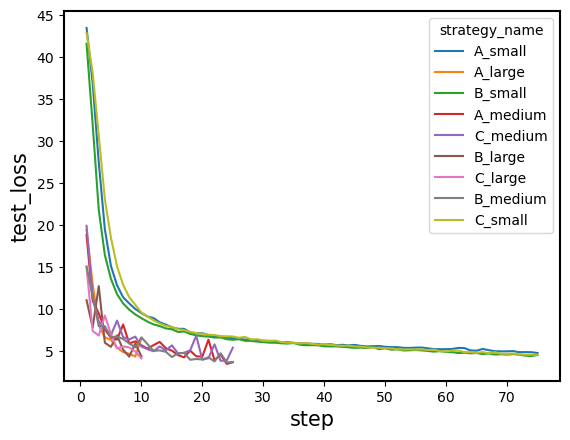

In [70]:
# losses_df.groupby('strategy_name').transform('')
sns.lineplot(losses_df, x='step', y='test_loss', hue='strategy_name')

In [71]:
from sklearn.decomposition import PCA

In [72]:
len(params_df)

5145

In [73]:
pca = PCA(n_components=3)
# ids = params_df['strategy_name'].isin(['A_small', 'A_medium', 'A_large',])
params_df.sort_values('step', inplace=True)
X = pca.fit_transform(params_df.drop(['lr', 'step', 'strategy_name'], axis=1))

In [74]:
params_df['strategy_name'].unique()

array(['A_small', 'C_large', 'B_small', 'C_medium', 'A_medium', 'A_large',
       'C_small', 'B_large', 'B_medium'], dtype=object)

In [75]:
start_id_ind = params_df['step'] == 1

fig_line = px.line(x=X[:, 0], y=X[:, 1], color=params_df['strategy_name'])
fig_line.update_traces(textposition="bottom right")

fig_start = px.scatter(x=X[start_id_ind, 0], y=X[start_id_ind, 1]).update_traces(marker_size=12)

fig_params = go.Figure(data=fig_line.data + fig_start.data)

fig_params.show()

In [76]:
px.line(losses_df, x='step_normed', y='train_loss', color='strategy_name')

In [79]:
px.line(losses_df, x='step_normed', y='test_loss', color='strategy_name')

In [77]:
import dill

In [78]:
dill.dump_session('main_dash.pkl')

In [64]:
# import dill
# dill.load_session('main_dash.pkl')